<a href="https://colab.research.google.com/github/jcausey-astate/ASRI-2025/blob/main/python_intermediate_regression_complete_ASRI25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Techniques in Python (Intermediate)
## ASRI 2025


![Regression in Python (Intermediate)](https://jcausey-astate.github.io/ASRI-2025/images/regression_in_python_title_card.svg)

The notebook uses the following modules:

* `matplotlib`  : Provides basic graphing/charting.
* `numpy`       : Allows matrix and vector/array math.
* `pandas`      : Provides DataFrame functionality.
* `seaborn`     : Works with `matplotlib` to provide nicer graphs.
* `sklearn`     : Scikit-Learn provides machine learning and data manipulation tools.

We will rely heavily on the Scikit-Learn library for models, metrics, and
experimental design tools.  See the full documentation for this fantastic
library at <https://scikit-learn.org>.

---

## First, some terms and definitions:

**_Regression_** is the process of predicting a _continuous value_ given
the _random variables_ for a given _sample_.

**_Continuous_** values are numeric values that can take on any value within
some range. Examples include height, weight, temperature, price, etc.

A **_sample_** consists of all of the experimental information gathered for one
item in the dataset.  Sometimes a _sample_ is called an _object_ or _item_.
Usually samples are arranged as _rows_ in tabular datasets (CSV files, Excel
spreadsheets, or similar).

A **_random variable_**, sometimes called an _input variable_, _measurement_, or
_feature_, is the recorded value for some property of the sample that was
measured in the experiment, e.g. "weight", "horsepower", "number of cylinders", etc.

#### You have a _regression_ problem if the dependent variable (output value) you are trying to predict is _continuous_.

We will focus first on regression problems where the random variables are
also _continuous_.

At the end, a section is provided with some tips for working with random variables that
are _categorical_.

___

## Let's see some code!

First, we have to import the modules, objects, and functions we will be using
in this tutorial:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

### The Dataset

For this tutorial, we will use the "Auto MPG" dataset, which is a classic dataset for regression tasks. 
It contains information about various automobiles, including their fuel consumption in miles per gallon (mpg, 
which will be our target variable to predict.

Let's load the dataset and take a look at it:

In [2]:
# Define column names based on the dataset description
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 
                'acceleration', 'model_year', 'origin', 'car_name']

# Download the dataset from UCI ML Repository if needed.
! [[ -f auto+mpg.zip ]] || { wget https://archive.ics.uci.edu/static/public/9/auto+mpg.zip && unzip -o auto+mpg.zip && rm Index auto-mpg.data-original; }

# Load the dataset
auto_mpg = pd.read_csv('auto-mpg.data', sep=r'\s+', names=column_names)

# Display the first few rows
auto_mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


The **mpg** column contains the value that we want to predict (it is our
_target_ column).  We'll use the other numeric columns as random
variables (predictors).

It will make things easier if we create variables to contain the name of the
target column and the random variables.  These can be used when we interact with
Pandas DataFrames to quickly select those columns by name.

In [3]:
target_col = "mpg"
random_var_cols = [
    "cylinders",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
    "model_year"
]

Let's use the `info()` DataFrame method to see what kinds of values we have, and
whether there are any missing values.

In [4]:
auto_mpg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


🤔  We notice that the 'horsepower' column is not recognized as numeric (the type is reported as "`object`"). Let's check if there are any non-numeric values.  

One way to do that is to look at the values.   Another is to write a function to check if each value can be converted to a `float`, and return True if it can or False otherwise.  Then, we can just filter for values that will not convert:

In [5]:
def is_number(x):
    """Returns True if `x` is a number, or False otherwise."""
    try:
        float(x)
    except ValueError:
        return False
    return True
# List the values and counts for all non-numeric values in the 'horsepower' variable:
auto_mpg.loc[auto_mpg['horsepower'].apply(is_number) == False, 'horsepower'].value_counts()

horsepower
?    6
Name: count, dtype: int64

From this, we can see that the only non-numeric value is '?'.  So, we could convert the column to numeric after replacing the '?' values with `na.nan`, or we can just reload the DataFrame from the CSV file and tell Pandas to treat '?' as NA.  We will do the latter to demonstrate how to do it, and because this dataset is small enough that it will not take long to do it that way.  (For larger data, the former approach would probably be faster.)

In [6]:
# Re-load the dataset, treating '?' as NA values.
auto_mpg = pd.read_csv('auto-mpg.data', sep=r'\s+', names=column_names, na_values='?')
# Check the info again
auto_mpg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


Now, we have correct data types.  We will still have missing values in 'horsepower' though, so we need to remove those rows:

ℹ️ Pandas has a method called `dropna()` that can drop missing values.

In this case, we want to call it with the `subset` argument set to our random variable cols (`random_var_cols`) and the `axis` argument set to 0.

In [7]:
# Now drop rows with missing values
auto_mpg = auto_mpg.dropna(subset=random_var_cols, axis=0)

### 📊 Visualize Early, Visualize Often

Let's take a look at the dataset.  We will plot some relationships between our target variable (mpg) and the predictors.   _(This will take several seconds.)_

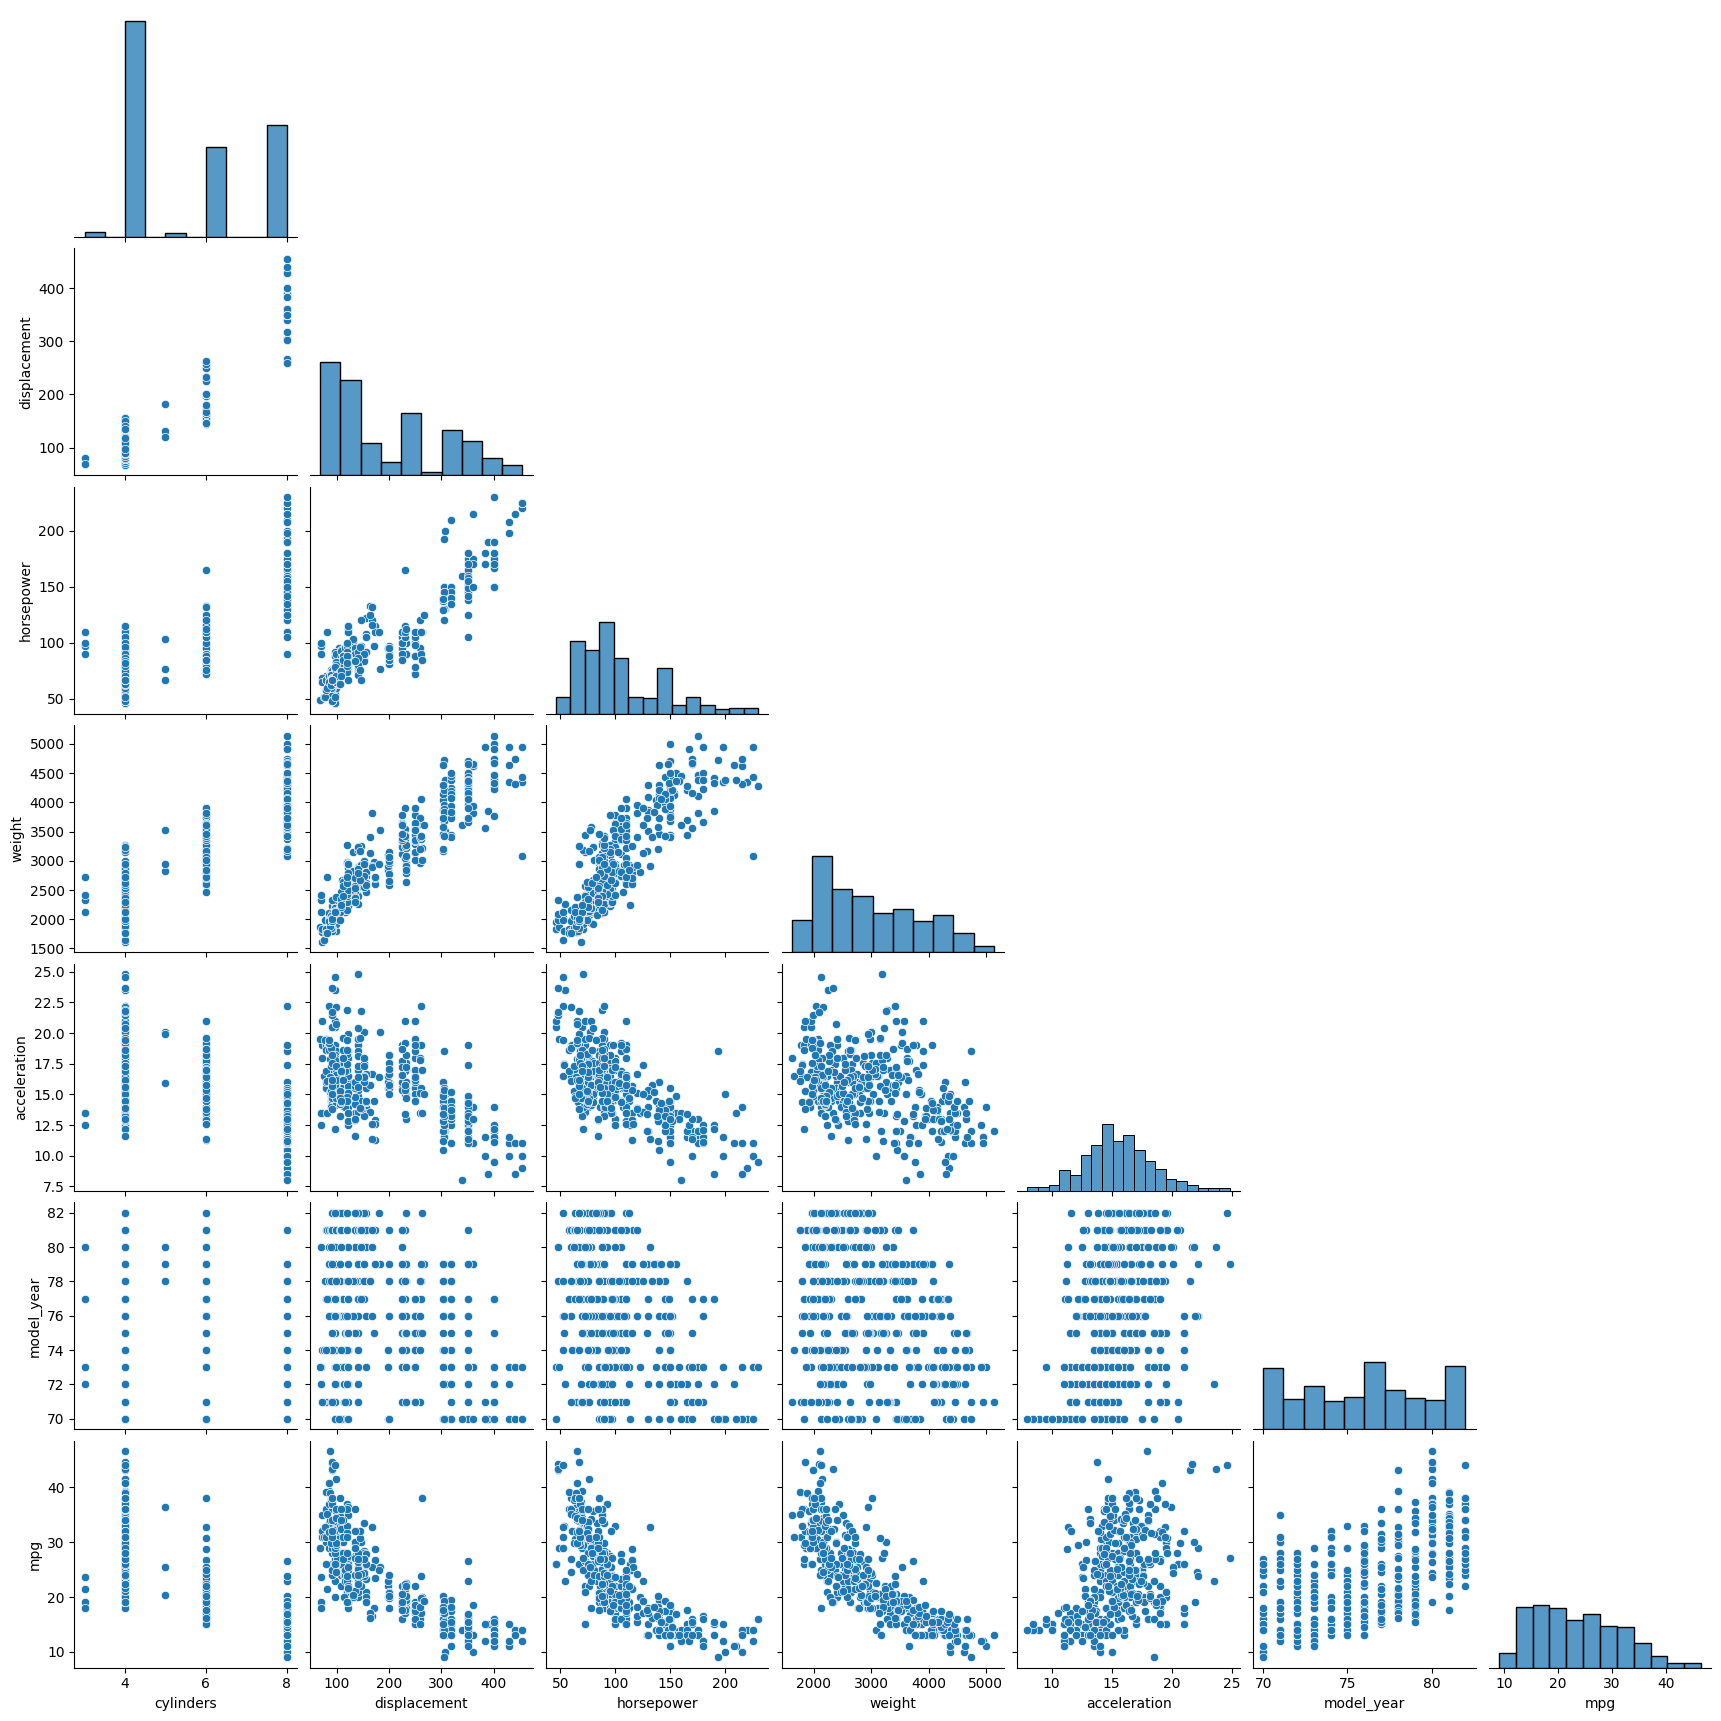

In [8]:
sns.pairplot(auto_mpg[random_var_cols + [target_col]], corner=True)

Looking at the pairplot, we can see that there are clear relationships between MPG and the various predictors (bottom row).
For example, as weight increases, MPG tends to decrease. Similarly, as horsepower and displacement increase, 
MPG tends to decrease. These relationships make intuitive sense: heavier cars with more powerful engines 
typically consume more fuel.  

We can also see that some of the predictors have relationships with one another, which could be a problem for 
models that assume independent variables.  Let's get a sense of that by plotting the (Spearman) _correlation_ 
between all the variables:

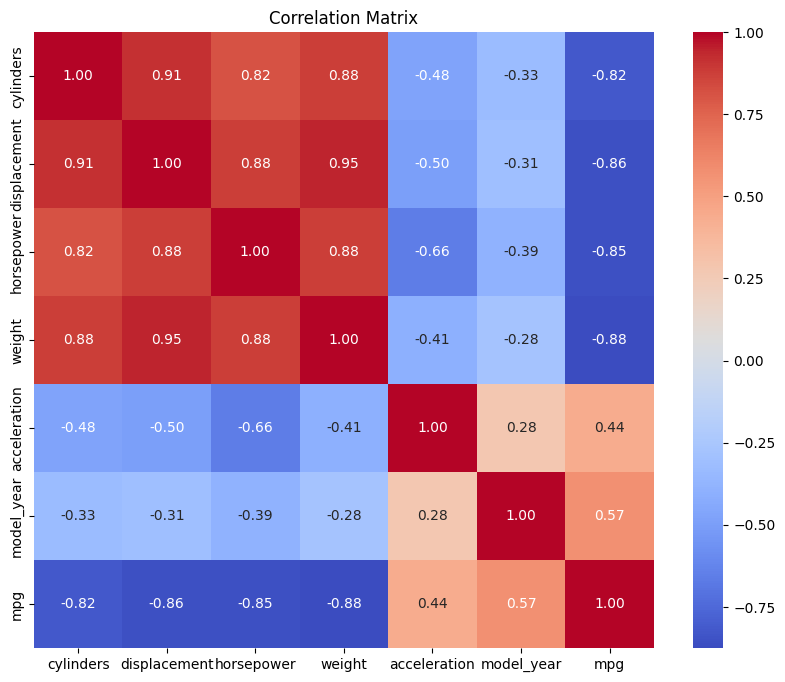

In [9]:
# Calculate correlation matrix.  We use Spearman because we observed some non-linear relationships in the pairplot.
correlation_matrix = auto_mpg[random_var_cols + [target_col]].corr('spearman')

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

The correlation matrix confirms our observations from the scatter plots. We can see strong negative correlations 
between MPG and weight, displacement, and horsepower. This suggests that these variables will be important 
predictors in our regression models.

✨ Choosing the right random variables for prediction is **vital**.  This is why
it is a good idea to get to know your dataset early in the process!  **Visualize
early, visualize often!**

## Let's see how well we can predict MPG with a linear model.

First, we'll use the `LinearRegression` model from scikit-learn.

Based on the visualizations above, let's start with a simple model using just weight and displacement as predictors:

In [ ]:
simple_random_var_cols = [
    "weight",
    "displacement",
]

For scoring, we will use _R²_ and Mean Absolute Error (MAE).


In [11]:
scoring_metrics = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
}

To quickly determine if a linear model will be suitable for this problem, we can use the
`cross_validate()` function from Scikit-Learn.  This function wraps up a
**lot** of functionality.  It will set up a [_k-fold cross validation_ experiment](https://scikit-learn.org/stable/modules/cross_validation.html)
(with default of $k=5$, for five-fold CV).  It will take the model of your
choice and automatically _train_ the model for each training fold, then
_predict_ the test cases and _score_ the predictions on the test folds (with the
_R²_ metric by default for regression).

The scores for each fold are returned.  We can calculate and report the mean
score over all five folds along with the standard deviation of the scores to see
whether the model is able to do a good job in general, and how much variation we
would expect for different training sets.  Models should have high R² values, and
a low standard deviation would indicate that the model generalizes to new data
very well.  (A high standard deviation would indicate the model is unstable and
doesn't generalize well.)  For the Mean Absolute Error metric, we want _smaller_ 
values (less deviation from the true mpg, and a small standard deviation.

The linear model will look like:

$$
y_{mpg} = \beta_0 + \beta_1 x_{weight} + \beta_2 x_{displacement}
$$



In [12]:
scores = cross_validate(
    LinearRegression(), X=auto_mpg[simple_random_var_cols], y=auto_mpg[target_col],
    scoring=scoring_metrics
)
print(
    f"mean R² : {scores['test_r2'].mean():0.3f}, std: {scores['test_r2'].std():0.3f}\n"
    f"mean MAE: {-scores['test_mae'].mean():0.1f} mpg, std: {scores['test_mae'].std():0.1f} mpg."
)  # print mean and standard deviation of score metrics

mean R² : 0.326, std: 0.523
mean MAE: 3.8 mpg, std: 1.4 mpg.


😞 The two-variable linear model seems pretty unstable at this task.  Look closely at the R² mean: 0.326 is a pretty low R² value to begin with, and the standard deviation over the 5 runs of the cross-validation experiment was 0.523, which is larger than the mean value!  That means that on average, the linear model can explain only about 33% of the variance in the data, and the high standard deviation means that the model is not generalizing very well.

🤔 We might have expected this if we look back at our pair plots of weight and displacement versus mpg.  Do you see the "curve" to the scatter?  That is a good indicator that a linear model might not be ideal for this task.

**Let's scale the model up to use all of our predictors.**

For now, we will stick with a linear model.  But, let's use all of our random variables to see if that improves the result.

In [13]:
scores = cross_validate(
    LinearRegression(), X=auto_mpg[random_var_cols], y=auto_mpg[target_col],
    scoring=scoring_metrics
)
print(
    f"mean R² : {scores['test_r2'].mean():0.3f}, std: {scores['test_r2'].std():0.3f}\n"
    f"mean MAE: {-scores['test_mae'].mean():0.1f} mpg, std: {scores['test_mae'].std():0.1f} mpg."
)  # print mean and standard deviation of score metrics

mean R² : 0.571, std: 0.231
mean MAE: 3.1 mpg, std: 0.8 mpg.


This provided a modest improvement, both in R² and standard deviation.  We see a smaller change in MAE and its standard deviation, but still an improvement nonetheless.

**Let's try a non-linear model.**  Let's consider a quadratic model (a polynomial model of degree 2).  The model will look like:

$$
y_{mpg} = \beta_0 + \beta_1 x_{weight} + \beta_2 x_{displacement} + \beta_3 x_{weight}^2 + \beta_4 x_{displacement}^2
$$

The way we do this is to pre-compute the polynomial features $x_{weight}^2$ and $x_{displacement}^2$, then use a linear regression model as before.

In [14]:
poly = PolynomialFeatures(degree=2, include_bias=False)
scores = cross_validate(
    LinearRegression(), X=poly.fit_transform(auto_mpg[random_var_cols]), y=auto_mpg[target_col],
    scoring=scoring_metrics
)
print(
    f"mean R² : {scores['test_r2'].mean():0.3f}, std: {scores['test_r2'].std():0.3f}\n"
    f"mean MAE: {-scores['test_mae'].mean():0.1f} mpg, std: {scores['test_mae'].std():0.1f} mpg."
)  # print mean and standard deviation of score metrics

mean R² : 0.679, std: 0.222
mean MAE: 2.6 mpg, std: 1.0 mpg.


🎉 Now we see a better result.  R² above 65% is starting to look more promising (but not necessarily "good").  We see that on average our model is off by about 2.6 mpg.  If that is an acceptable error amount, we might be happy with this one.  

Now, let's take a look at a different kind of model, just for comparison.  A _Random
Forest_ model is a non-linear model that works well for lots of tasks.
Scikit-Learn provides one called [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) for regression problems.

Let's try it in exactly the same experimental setup we used for the linear
model.

In [15]:
scores = cross_validate(
    RandomForestRegressor(random_state=1),
    X=auto_mpg[random_var_cols],
    y=auto_mpg[target_col],
    scoring=scoring_metrics
)
print(
    f"mean R² : {scores['test_r2'].mean():0.3f}, std: {scores['test_r2'].std():0.3f}\n"
    f"mean MAE: {-scores['test_mae'].mean():0.1f} mpg, std: {scores['test_mae'].std():0.1f} mpg."
)  # print mean and standard deviation of score metrics

mean R² : 0.748, std: 0.198
mean MAE: 2.2 mpg, std: 0.8 mpg.


The random forest did even better than the quadratic model! This suggests that there might be non-linear relationships in the data that the random forest is able to capture better than either the linear or quadratic models.

**One note:**

We used `random_state=1` to _seed_ the random number generator within the model,
causing it to produce identical results if we train it again on the same data.
Random forests (as implied by their name) rely on some randomness during
training, so you don't expect to get the same performance every time.  This
makes **reproducible results** difficult.

💡 By seeding the random state, we "lock" it to a specific outcome (assuming no
external changes).  This way, others can reproduce our results in the future.


## Exploring more ways to characterize regressor performance.

### 📊 Visualize!

When evaluating regression models, it's important to look at the residuals (the differences between predicted and actual values). 
A good regression model should have residuals that are randomly distributed around zero.

Let's split our data into training and testing sets, train our models, and then visualize the residuals:

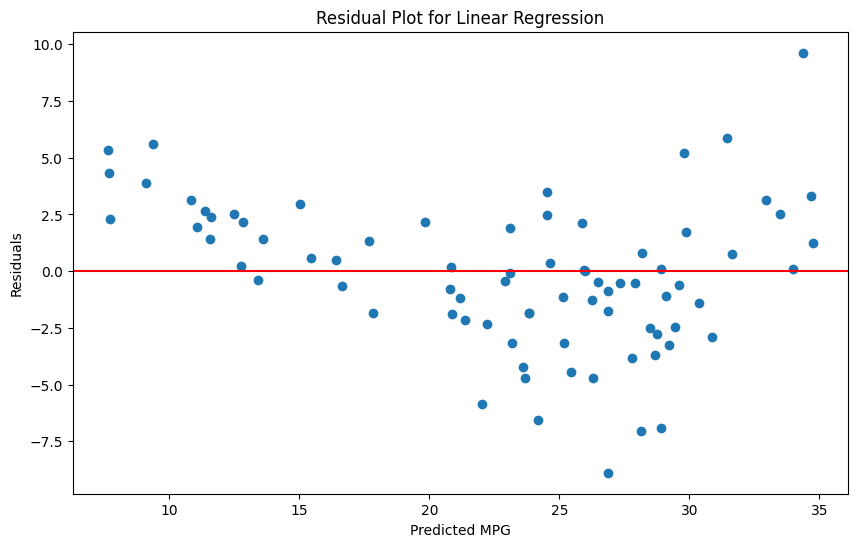

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    auto_mpg[random_var_cols], auto_mpg[target_col], test_size=0.2, random_state=42
)

# Train the linear regression model
linear_model = LinearRegression().fit(X_train, y_train)

# Make predictions on the test set
linear_preds = linear_model.predict(X_test)

# Calculate residuals
linear_residuals = y_test - linear_preds

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(linear_preds, linear_residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted MPG')
plt.ylabel('Residuals')
plt.title('Residual Plot for Linear Regression')
plt.show()

✨ **Interpreting a residual plot:**  To interpret a residual plot like the one above, we look at two things: (1) The magnitude of the residuals, which represents how far our predictions are from the actual values.  We want the dots to be close to the zero line.  (2) The **_shape_** of the residuals.  The plotted residuals are ordered by magnitude of the prediction from smallest to largest, covering the range of predicted values.  What we _want_ is to see no trend or "pattern" to the scatter of residuals versus the zero line.  If we see a trend or pattern, then it is a clue that our model is not making the same mistakes across the range of its outputs, and so it might not be a good fit for the application.

Here, we see that there is a "curve" in the residuals&mdash;they start above the zero line, trend downward, then back up again (a "smile" pattern).  This is a clue that the actual target variable "mpg" is probably not a linear function of the predictors.  A non-linear model might work better.


Now let's do the same plot for the Random Forest model:

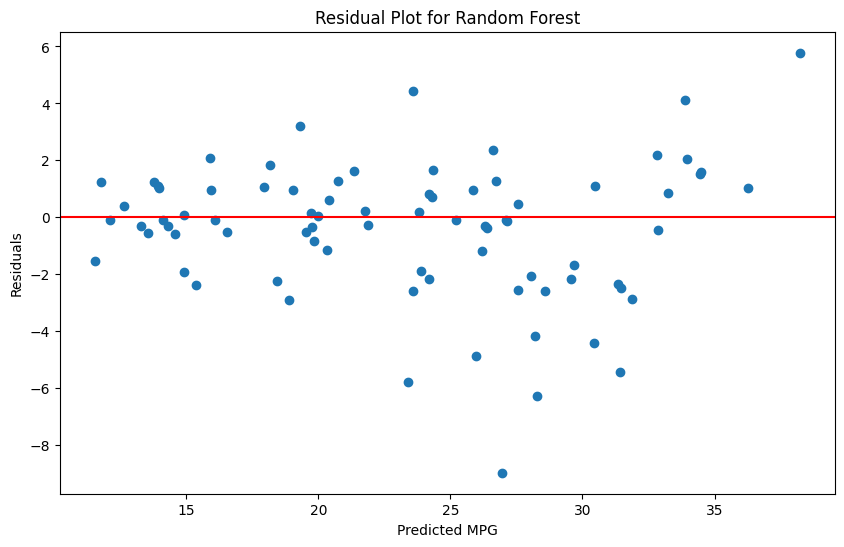

In [17]:
# Train the random forest model
rf_model = RandomForestRegressor(random_state=1).fit(X_train, y_train)

# Make predictions on the test set
rf_preds = rf_model.predict(X_test)

# Calculate residuals
rf_residuals = y_test - rf_preds

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(rf_preds, rf_residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted MPG')
plt.ylabel('Residuals')
plt.title('Residual Plot for Random Forest')
plt.show()

**Here, we don't see as much of a pattern.** That is a _good thing_.  For the most part, our Random Forest model seems to be making similar errors across its range, with two possible exceptions: The smaller predictions seem to be better than the larger ones in general, and there is a rough patch between about 22 and 32 mpg. where the model seems to be over-predicting more than everywhere else.  An even more powerful model might be able to do a better job, but we won't investigate that in this workshop.

💡 **Another way to visualize the errors:** Let's also compare the _actual vs. predicted_ values for both models:

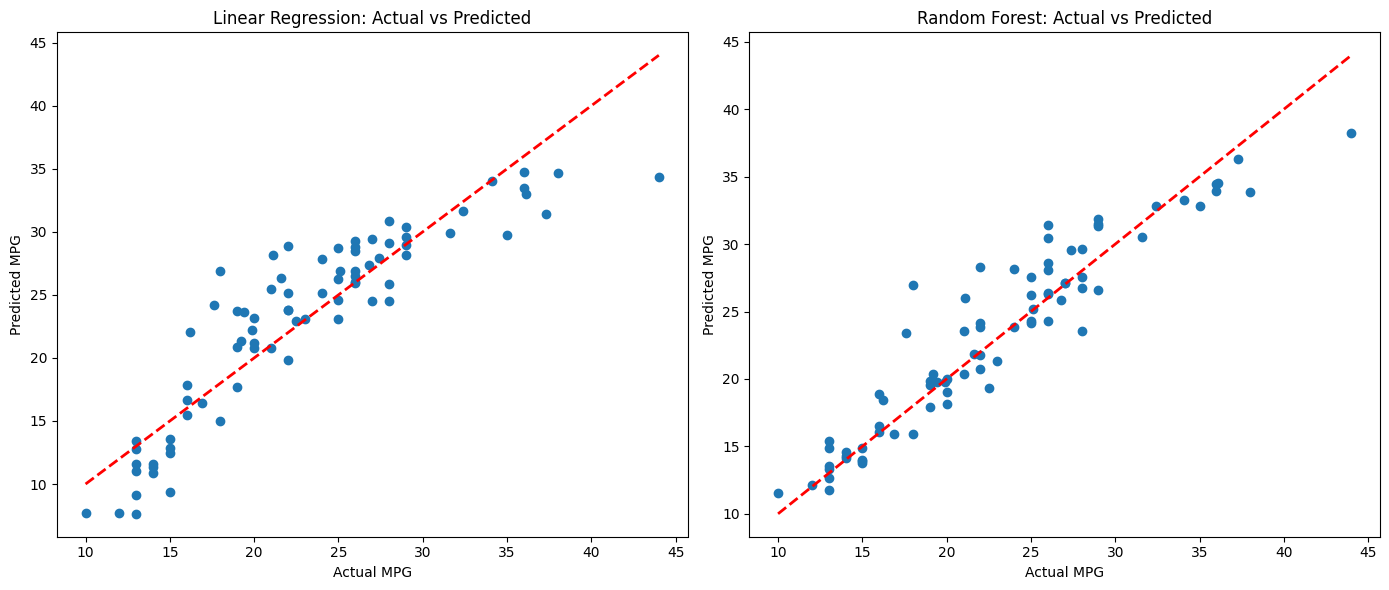

In [18]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot actual vs predicted for Linear Regression
ax1.scatter(y_test, linear_preds)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual MPG')
ax1.set_ylabel('Predicted MPG')
ax1.set_title('Linear Regression: Actual vs Predicted')

# Plot actual vs predicted for Random Forest
ax2.scatter(y_test, rf_preds)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual MPG')
ax2.set_ylabel('Predicted MPG')
ax2.set_title('Random Forest: Actual vs Predicted')

plt.tight_layout()
plt.show()

**Interpretation:**  To interpret these plots, keep in mind that the dotted red line represents a "perfect fit" model.  We don't expect every dot to be on the line, but we want them _close_ and _randomly spread_ around it (no patterns).  On the left plot (the linear model), we see a "bent" scatter of points compared to the line, indicating a bad fit.  On the right, the Random Forest (RF) behaves better, but we can see the over-prediction in the mid-range and then the beginnings of under-prediction happing at the top end (similar to what we see on the linear model's graph).  Again, the RF looks better, but leaves room for improvement.

### Non-visual metrics

Let's look at other regression metrics.

Scikit-Learn provides several metrics appropriate for evaluating regression
models.  You can see the list at
<https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics>.

We'll calculate some common metrics for both models:

In [19]:
# Calculate metrics for Linear Regression
linear_mse = mean_squared_error(y_test, linear_preds)
linear_rmse = np.sqrt(linear_mse)
linear_mae = mean_absolute_error(y_test, linear_preds)
linear_msd = np.mean(linear_preds-y_test)
linear_r2 = r2_score(y_test, linear_preds)

# Calculate metrics for Random Forest
rf_mse = mean_squared_error(y_test, rf_preds)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_msd = np.mean(rf_preds-y_test)
rf_r2 = r2_score(y_test, rf_preds)

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MSE': [linear_mse, rf_mse],
    'RMSE': [linear_rmse, rf_rmse],
    'MAE': [linear_mae, rf_mae],
    'MSD': [linear_msd, rf_msd],
    'R²': [linear_r2, rf_r2]
})

metrics_df

,Model,MSE,RMSE,MAE,MSD,R²
0,Linear Regression,10.502370,3.240736,2.503860,0.179652,0.794235
1,Random Forest,5.876812,2.424214,1.732253,0.409367,0.884860


Let's understand these metrics:

- **Mean Squared Error (MSE)**: The average of the squared differences between predicted and actual values. Lower is better.
- **Root Mean Squared Error (RMSE)**: The square root of MSE. It's in the same units as the target variable, making it more interpretable. Lower is better.
- **Mean Absolute Error (MAE)**: The average of the absolute differences between predicted and actual values. Lower is better.
- **Mean Signed Deviation (MSD)**: The average of the differences between predicted and actual values, retaining the sign.  Closer to zero is better, and the sign indicates the direction of the bias (e.g. model is over-predicting vs. under-predicting).
- **R² (Coefficient of Determination)**: Represents the proportion of variance in the dependent variable that is predictable from the independent variables. Ranges from 0 to 1, with higher values indicating better fit.

Based on these metrics, the Random Forest model outperforms the Linear Regression model on our test set.  However, MSD reveals that the RF model is a bit more biased toward over-predicting the mpg than the linear model.  So, when RF makes a mistake, it is more likely to favor higher mpg.

### Feature Importance

Some models can provide information about the importance of each featuer, allowing us to understand the underlying process better and perhaps perform feature selection to simplify our models.  Different models do this differently.

**Linear Regression** models convey feature importance in the magnitude of the coefficients they compute for each feature.  You can access this information for Scikit-Learn `LinearRegression` models in the `coef_` attribute:

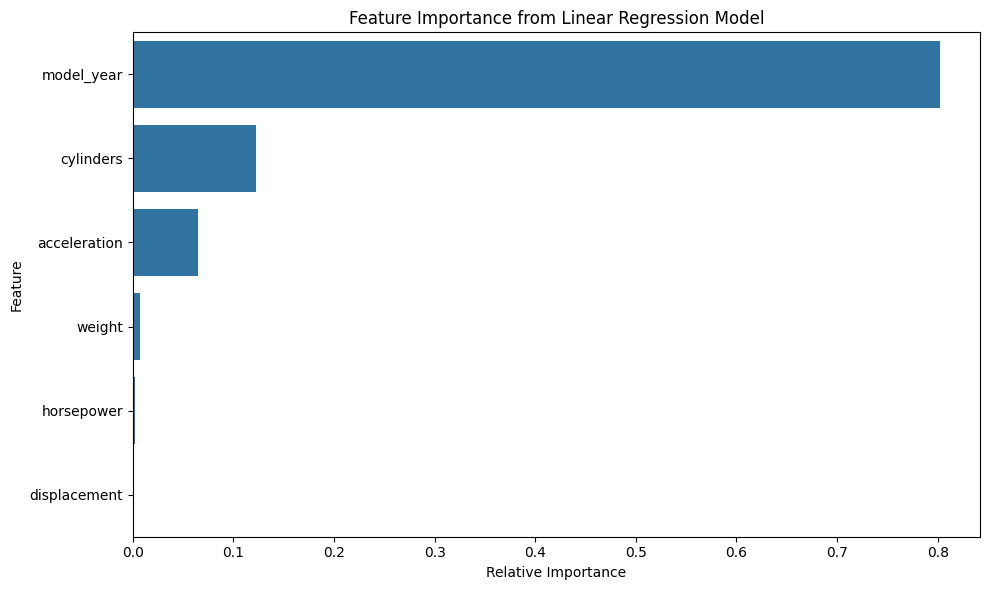

In [20]:
# We will get the absolute values of the coefficients, since we don't care about direction here
linear_feature_importance = np.abs(linear_model.coef_)
# And then normalize them so that they sum to 1.0 just to make the scale easier to interpret.
linear_feature_importance /= np.sum(linear_feature_importance)

# Create a DataFrame to display feature importance
linear_importance_df = pd.DataFrame({
    'Feature': random_var_cols,
    'Importance': linear_feature_importance
})

# Sort by importance
linear_importance_df = linear_importance_df.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=linear_importance_df)
plt.title('Feature Importance from Linear Regression Model')
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()

📈 We can see from this that "model_year" had the most impact on the linear model.  Looking back at the original scatterplots, we can see that model year does have a mostly-linear trend where mpg tends to increase in more recent years.



The `RandomForestRegressor` model provides feature importance information in its `feature_importances_` attribute:

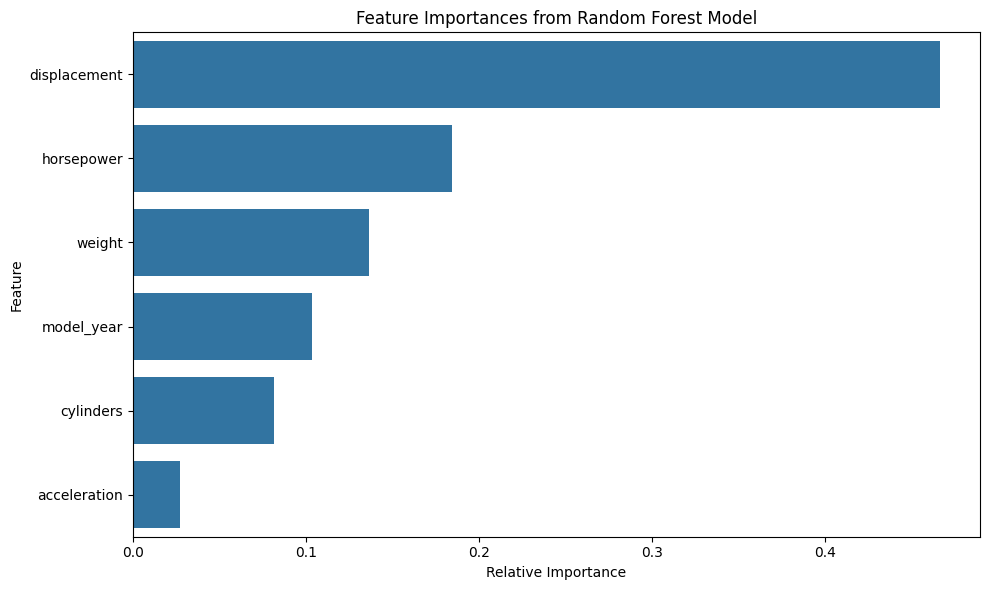

In [21]:
# Get feature importances from the Random Forest model (it is already normalized to sum to 1.0).
rf_feature_importance = rf_model.feature_importances_

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame({
    'Feature': random_var_cols,
    'Importance': rf_feature_importance
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest Model')
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()

🤔 Notice that the RF model has a different conclusion about which feature is most important, choosing "displacement".  Displacement seemed highly correlated with mpg in the original scatterplot, but the relationship is highly non-linear, and has redundancy with "cylinders" and "horsepower".  The RF was able to use this variable in spite of these challenges.

## Working with categorical features

So far, we've only used numeric features for our predictors. But the Auto MPG dataset also contains a categorical feature:

* `origin` - three levels: [1, 2, 3] representing American, European, and Japanese cars respectively

Let's convert this numeric encoding to more meaningful labels first:

In [22]:
# Create a mapping dictionary
origin_map = {1: 'American', 2: 'European', 3: 'Japanese'}

# Create a new column with the mapped values
auto_mpg['origin_name'] = auto_mpg['origin'].map(origin_map)

# Display the first few rows to verify
auto_mpg[['origin', 'origin_name']].head()

,origin,origin_name
0,1,American
1,1,American
2,1,American
3,1,American
4,1,American


Now let's visualize how MPG varies by origin:

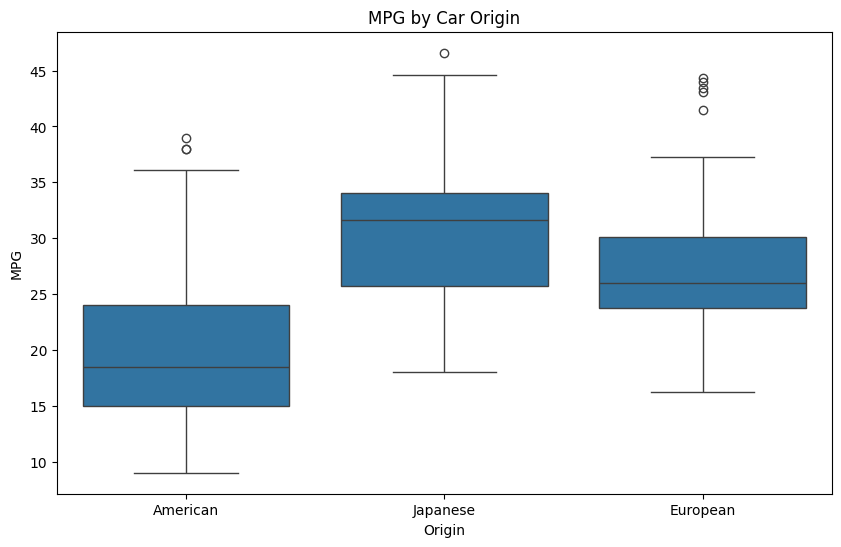

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='origin_name', y='mpg', data=auto_mpg)
plt.title('MPG by Car Origin')
plt.xlabel('Origin')
plt.ylabel('MPG')
plt.show()

We can see that there are differences in MPG based on the car's origin. Japanese cars tend to have higher MPG, followed by European cars, with American cars having the lowest MPG on average.

To include this categorical variable in our regression models, we need to encode it. One common approach is **_one-hot encoding_**.

**_One-hot encoding_** is an encoding technique in which a variable with $N$ levels is split into $N$ new _pseudo-variables_ where each is a binary variable encoded as 1 or 0.

Let's see how our `origin` variable might look if it were one-hot encoded:

**Before**

    mpg  cylinders  displacement  ...  origin  car_name
    20.5  6         200.0         ...  1       chevrolet malibu
    15.0  8         350.0         ...  1       buick skylark 320
    22.0  4         121.0         ...  2       volkswagen 411 (sw)
    26.0  4         98.00         ...  2       fiat 124 sport coupe
    32.0  4         71.00         ...  3       toyota corolla 1200
    24.0  4         120.0         ...  3       honda civic

**After**

    mpg  cylinders  displacement  ...  origin_American  origin_European  origin_Japanese  car_name
    20.5  6         200.0         ...  1                0                0                chevrolet malibu
    15.0  8         350.0         ...  1                0                0                buick skylark 320
    22.0  4         121.0         ...  0                1                0                volkswagen 411 (sw)
    26.0  4         98.00         ...  0                1                0                fiat 124 sport coupe
    32.0  4         71.00         ...  0                0                1                toyota corolla 1200
    24.0  4         120.0         ...  0                0                1                honda civic


**Here's the code:**

Pandas can do this in a dataframe by using the `get_dummies()` method.  You provide a prefix
(like `"origin"`) and the existing levels are used to complete the new column names.


In [24]:
sample_rows = [253, 1, 77, 114, 131, 149] # this lets us select the same cars shown above
auto_mpg_encoded = pd.get_dummies(        # get_dummies converts to one-hot encoding
    auto_mpg, columns=["origin_name"], prefix="origin", dtype=int
)
auto_mpg_encoded.loc[sample_rows][['mpg', 'origin_American', 'origin_European', 'origin_Japanese', 'car_name']]

,mpg,origin_American,origin_European,origin_Japanese,car_name
253,20.5,1,0,0,chevrolet malibu
1,15.0,1,0,0,buick skylark 320
77,22.0,0,1,0,volkswagen 411 (sw)
114,26.0,0,1,0,fiat 124 sport coupe
131,32.0,0,0,1,toyota corolla 1200
149,24.0,0,0,1,honda civic


Now let's use these one-hot encoded features in our regression models:

In [25]:
# Define columns including one-hot encoded origin
all_features = random_var_cols + ['origin_American', 'origin_European', 'origin_Japanese']

Now we will evaluate each of our models with a 5-fold CV like we did in the beginning, and compare the original features to the ones with origin information included:

In [26]:
# create a helper function so we don't have to repeat this code too much
def do_evaluation(model, X, y, caption):
    scores = cross_validate( model, X, y, scoring=scoring_metrics)
    print(
        f"{caption}\n"
        f"mean R² : {scores['test_r2'].mean():0.3f}, std: {scores['test_r2'].std():0.3f}\n"
        f"mean MAE: {-scores['test_mae'].mean():0.1f} mpg, std: {scores['test_mae'].std():0.2f} mpg.\n"
    )  # print mean and standard deviation of score metrics

In [27]:
do_evaluation(LinearRegression(), X=auto_mpg[random_var_cols], y=auto_mpg[target_col], caption="Linear Regression without origin info:")
do_evaluation(LinearRegression(), X=auto_mpg_encoded[all_features], y=auto_mpg_encoded[target_col], caption="Linear Regression including origin info:")

print("---\n")

poly = PolynomialFeatures(degree=2, include_bias=False)
do_evaluation(LinearRegression(), X=poly.fit_transform(auto_mpg[random_var_cols]), y=auto_mpg[target_col], caption="Polynomial (d=2) Regression without origin info:")
do_evaluation(LinearRegression(), X=poly.fit_transform(auto_mpg_encoded[all_features]), y=auto_mpg_encoded[target_col], caption="Polynomial (d=2) Regression including origin info:")

print("---\n")

do_evaluation(RandomForestRegressor(random_state=1), X=auto_mpg[random_var_cols], y=auto_mpg[target_col], caption="Random Forest regression without origin info:")
do_evaluation(RandomForestRegressor(random_state=1), X=auto_mpg_encoded[all_features], y=auto_mpg_encoded[target_col], caption="Random Forest regression including origin info:")


Linear Regression without origin info:
mean R² : 0.571, std: 0.231
mean MAE: 3.1 mpg, std: 0.76 mpg.

Linear Regression including origin info:
mean R² : 0.594, std: 0.197
mean MAE: 3.0 mpg, std: 0.68 mpg.

---

Polynomial (d=2) Regression without origin info:
mean R² : 0.679, std: 0.222
mean MAE: 2.6 mpg, std: 0.97 mpg.

Polynomial (d=2) Regression including origin info:
mean R² : 0.661, std: 0.210
mean MAE: 2.6 mpg, std: 0.85 mpg.

---

Random Forest regression without origin info:
mean R² : 0.748, std: 0.198
mean MAE: 2.2 mpg, std: 0.76 mpg.

Random Forest regression including origin info:
mean R² : 0.752, std: 0.194
mean MAE: 2.2 mpg, std: 0.77 mpg.



Including the origin as a categorical feature has improved our model performance in the linear regression and quadratic models, but not significantly.  The RF model was mostly unchanged by the addition of this variable.  

However, categorical variables can be very important in some datasets!  Consider encoding them and using them in the model; you can evaluate whether or not it was worthwhile before training your final model version.

#### There's More Than One Way to Do It

You can also use the `OneHotEncoder` from Scikit-Learn to encode categorical variables. It's particularly useful when you don't want to modify your original dataframe and prefer to create a "data pipeline" for preprocessing your data during training or inference.

In fact, there are _several_ other approaches to encoding categorical values.  

You can learn a lot more here: <https://www.kaggle.com/code/arashnic/an-overview-of-categorical-encoding-methods>

## Thank You!

This notebook in tutorial and completed form is available at:

<https://jcausey-astate.github.io/ASRI-2025/>
